In [1]:
import cv2
import numpy as np
import os
from skimage.util import img_as_float
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.path as mplPath
import util
from timeit import default_timer as timer
from datetime import datetime
from skimage.segmentation import mark_boundaries

In [2]:
folderPageImages = 'parzivalDataset'; 
folderGroundThruth = 'groundTruth'

#### Leyendo las imágenes de los documentos y sus respectivos archivos XML que contienen los segmentos (ground truth) como coordenadas de polígonos


In [3]:
startTime = datetime.now()   
ximg_train,      xgt_train      = util.readPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'train', 2**-3)     
ximg_test,       xgt_test       = util.readPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'test', 2**-3)
ximg_validation, xgt_validation = util.readPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'validation', 2**-3)
print("Time taken:", datetime.now() - startTime)

Time taken: 0:00:17.714445


index 7 to samples

#### Segmentando las imágenes en super píxeles, usando la técnica  SLIC - Es necesario hacer ésta segmentación con los 3 canales de colores

In [4]:
startTime = datetime.now()
ximg_train_superpixels      = util.segmentImageInSuperpixels(ximg_train, 3000)
ximg_test_superpixels       = util.segmentImageInSuperpixels(ximg_test, 3000)
ximg_validation_superpixels = util.segmentImageInSuperpixels(ximg_validation, 3000)
print("Time taken:", datetime.now() - startTime)

Time taken: 0:01:46.856021


### Guardando los superpíxeles extraidos por cada imagen

In [5]:
util.saveObject(ximg_train_superpixels,       'pathSuperPixelesTrain')
util.saveObject(ximg_test_superpixels,        'pathSuperPixelesTest')
util.saveObject(ximg_validation_superpixels,  'pathSuperPixelesValidation')

ximg_train_superpixels      = util.readObject('pathSuperPixelesTrain')
ximg_test_superpixels       = util.readObject('pathSuperPixelesTest')
ximg_validation_superpixels = util.readObject('pathSuperPixelesValidation')

### Convirtiendo las imágenes a escala de grises 

In [6]:
# ximg_train = util.convertToGrayscale(ximg_train)
# ximg_test = util.convertToGrayscale(ximg_test)
# ximg_validation = util.convertToGrayscale(ximg_validation)

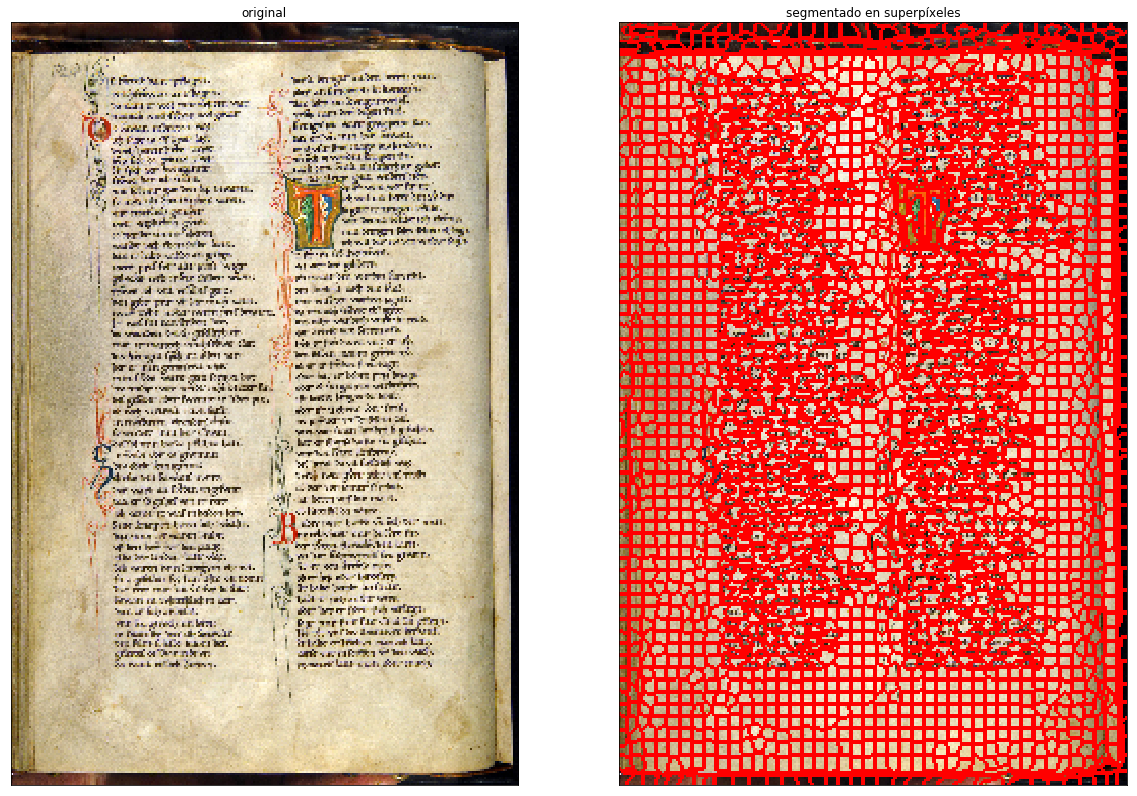

Time taken: 0:00:00.625958


In [7]:
startTime = datetime.now()
image = ximg_train[7]
imgSegmented = mark_boundaries(image.copy(), ximg_train_superpixels[7], color=(1, 0, 0), outline_color=None)
util.subplot(titles=['original','segmentado en superpíxeles'], images = [image, imgSegmented], rows = 1, imgPerRows = 2, size = 20)
print("Time taken:", datetime.now() - startTime)        

In [8]:
startTime = datetime.now()
imagePoints = imgSegmented.copy()
util.paintCentralPointsOrPatchesSegments (imagePoints , ximg_train_superpixels[7], 1, 0, 0,False)
print("Time taken:", datetime.now() - startTime)            

Time taken: 0:00:00.547872


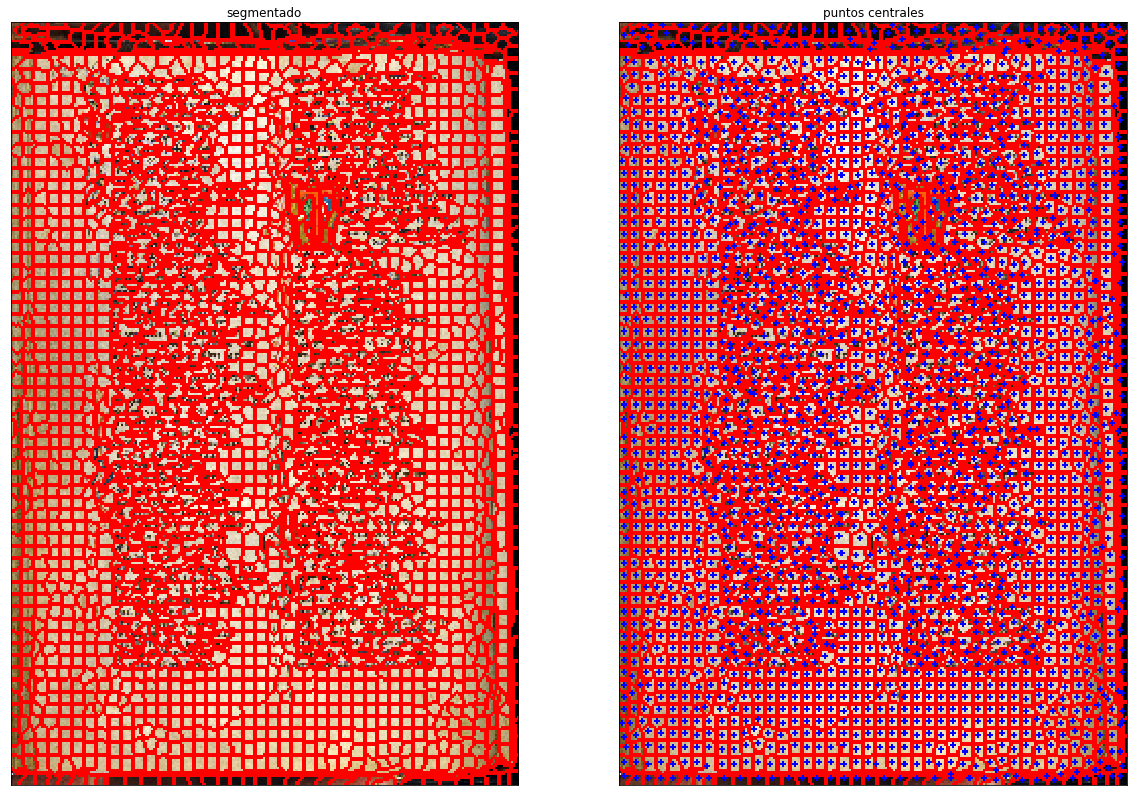

Time taken: 0:00:00.511884


In [9]:
startTime = datetime.now()
util.subplot(titles=['segmentado','puntos centrales'], images = [imgSegmented, imagePoints], rows = 1, imgPerRows = 2, size = 20)
print("Time taken:", datetime.now() - startTime)  

In [10]:
startTime = datetime.now()
imagePatches = imagePoints.copy()
util.paintCentralPointsOrPatchesSegments (imagePatches , ximg_train_superpixels[7], 0, 1, 28, True)
print("Time taken:", datetime.now() - startTime)      

Time taken: 0:00:00.582411


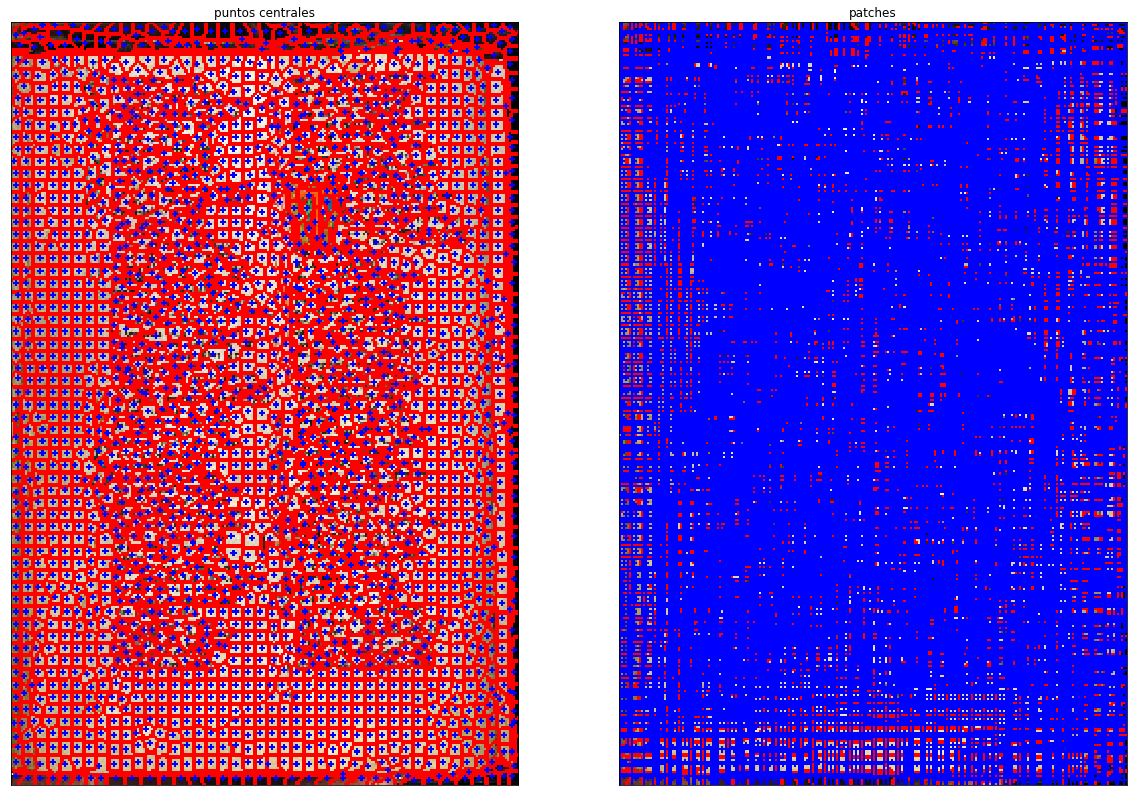

In [11]:
util.subplot(titles=['puntos centrales','patches'], images = [imagePoints, imagePatches], rows = 1, imgPerRows = 2, size = 20)

In [12]:
print(np.shape(ximg_train_superpixels))

(24, 376, 250)


### Generando los ejemplares de entrenamiento con sus respectivos puntos centrales y superpíxel asociado 

In [13]:
import importlib
importlib.reload(util)
startTime = datetime.now()
XTrain, XCentralPointsTrain, listSuperPixelesProcessedTrain = util.doInputs(ximg_train, ximg_train_superpixels, 28, 'train')
XTest, XCentralPointsTest, listSuperPixelesProcessedTest = util.doInputs(ximg_test, ximg_test_superpixels, 28, 'test')
XValidation, XCentralPointsValidation, listSuperPixelesProcessedValidation = util.doInputs(ximg_validation, ximg_validation_superpixels, 28, 'validation')
print("Time taken:", datetime.now() - startTime)          

Time taken: 0:00:29.795929


In [14]:
print(np.shape(XTrain[0]))
print(np.shape(XTest))
print(np.shape(XValidation))

(2082, 28, 28)
(13,)
(2,)


In [15]:
ximg_train = util.convertToGrayscale(ximg_train)
ximg_test = util.convertToGrayscale(ximg_test)
ximg_validation = util.convertToGrayscale(ximg_validation)

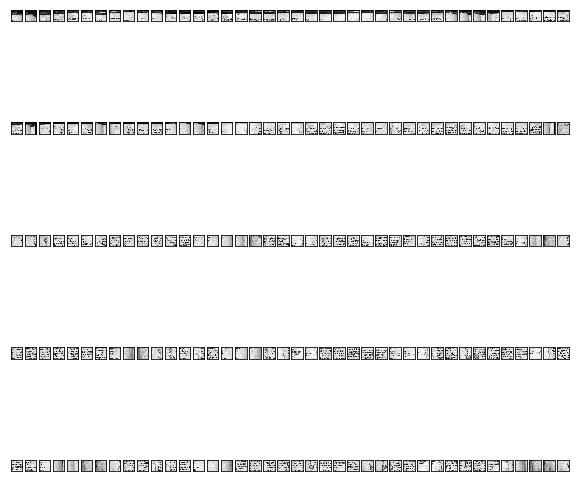

Time taken: 0:00:12.284813


In [16]:
startTime = datetime.now()
fig, ax = plt.subplots(figsize=(10,10))
for i in range(200):
    plt.subplot(5,40,i+1),plt.imshow(XTrain[7][i],'gray')
    plt.title("")
    plt.xticks([]),plt.yticks([])
plt.show()
print("Time taken:", datetime.now() - startTime)     

### Obteniendo las clases o etiquetas por cada ejemplar de entrenamiento (patch)

In [17]:
import importlib
importlib.reload(util)
startTime = datetime.now()
YTrain      = util.doLabels(XCentralPointsTrain,      xgt_train,      folderGroundThruth, 'train', 2**3)
YTest       = util.doLabels(XCentralPointsTest,       xgt_test,       folderGroundThruth, 'test', 2**3)
YValidation = util.doLabels(XCentralPointsValidation, xgt_validation, folderGroundThruth, 'validation', 2**3)
print("Time taken:", datetime.now() - startTime)

Time taken: 0:47:33.837613


In [18]:
from collections import Counter
Counter(YTrain[0])

Counter({'comment': 12,
         'decoration': 10,
         'page': 1147,
         'periphery': 29,
         'text': 884})

In [19]:
from collections import Counter
Counter(YTest[0])

Counter({'comment': 60,
         'decoration': 12,
         'page': 1095,
         'periphery': 17,
         'text': 955})

In [20]:
from collections import Counter
Counter(YValidation[0])

Counter({'comment': 13,
         'decoration': 9,
         'page': 1037,
         'periphery': 118,
         'text': 905})

In [22]:
startTime = datetime.now()
image = ximg_train[7]
vis = np.zeros([image.shape[0], image.shape[1], 3], dtype="uint8")
superpixels = listSuperPixelesProcessedTrain[7]
print(len(superpixels))
for i in range(len(superpixels)) :
    if YTrain[7][i] == 'text' :    
        vis[superpixels[i] == 255] = (0, 0, 255)
    elif YTrain[7][i] == 'decoration' :
        vis[superpixels[i] == 255] = (255, 0, 0)
    elif YTrain[7][i] == 'comment' :
        vis[superpixels[i] == 255] = (0, 255, 0)
    elif YTrain[7][i] == 'page' :
        vis[superpixels[i] == 255] = (255, 255, 255)
    elif YTrain[7][i] == 'periphery' :
        vis[superpixels[i] == 255] = (0, 0, 0)        
                    

2076


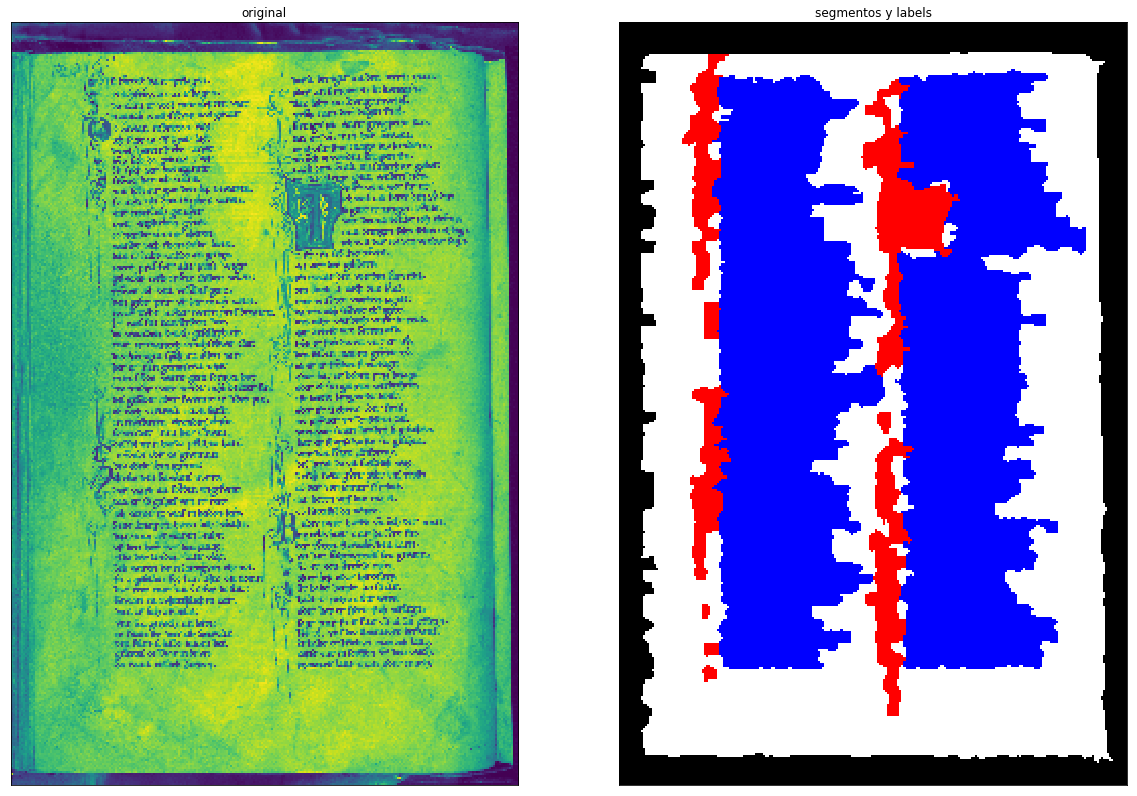

In [31]:
from skimage.exposure import rescale_intensity
image = rescale_intensity(image, out_range=(0, 255)).astype("uint8")
util.subplot(titles=['original','segmentos y labels'], images = [image, vis], rows = 1, imgPerRows = 2, size = 20)


#### Persistiendo los ejemplares de entrenamiento y sus etiquetas 

In [32]:
util.saveObject(XTrain, 'pathXTrain')
util.saveObject(XTest, 'pathXTest')
util.saveObject(XValidation, 'pathXValidation')

util.saveObject(YTrain, 'pathYTrain')
util.saveObject(YTest, 'pathYTest')
util.saveObject(YValidation, 'pathYValidation')
